In this sheet I will apply Convolutional Neural Networks for stock prediction of Apple stock price. I will divide data from last 15 years into chunks. Every day contains one opening value. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 150
TEST_SIZE = 0.2
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True
PREDICTION_LABEL = 'Open'

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,10.284286,10.302857,10.092857,10.141429,8.779409,197810200
196,196,2006-02-28,10.225715,10.342857,9.728572,9.784286,8.470230,316745100
197,197,2006-03-01,9.834286,9.927143,9.717143,9.871428,8.545672,190954400
198,198,2006-03-02,9.855714,9.998571,9.810000,9.944285,8.608742,156318400


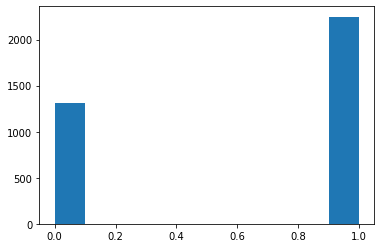

1    2248
0    1307
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[[PREDICTION_LABEL]].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2844, 200, 1), (2844,), (711, 200, 1), (711,))

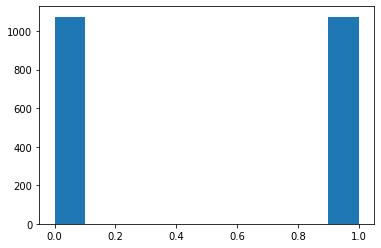

0.0    1074
1.0    1074
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 1), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binary-weights.h5')

Train on 2148 samples, validate on 711 samples
Epoch 1/150
2148/2148 [==============================] - 1s 529us/step - loss: 0.8339 - tp: 754.0000 - fp: 716.0000 - tn: 358.0000 - fn: 320.0000 - accuracy: 0.5177 - precision: 0.5129 - recall: 0.7020 - auc: 0.5204 - val_loss: 0.6941 - val_tp: 273.0000 - val_fp: 174.0000 - val_tn: 59.0000 - val_fn: 205.0000 - val_accuracy: 0.4669 - val_precision: 0.6107 - val_recall: 0.5711 - val_auc: 0.4376
Epoch 2/150
2148/2148 [==============================] - 0s 189us/step - loss: 0.7747 - tp: 685.0000 - fp: 611.0000 - tn: 463.0000 - fn: 389.0000 - accuracy: 0.5345 - precision: 0.5285 - recall: 0.6378 - auc: 0.5472 - val_loss: 0.7042 - val_tp: 288.0000 - val_fp: 180.0000 - val_tn: 53.0000 - val_fn: 190.0000 - val_accuracy: 0.4796 - val_precision: 0.6154 - val_recall: 0.6025 - val_auc: 0.4514
Epoch 3/150
2148/2148 [==============================] - 0s 171us/step - loss: 0.7251 - tp: 652.0000 - fp: 499.0000 - tn: 575.0000 - fn: 422.0000 - accuracy: 0.5

2148/2148 [==============================] - 0s 167us/step - loss: 0.5670 - tp: 743.0000 - fp: 314.0000 - tn: 760.0000 - fn: 331.0000 - accuracy: 0.6997 - precision: 0.7029 - recall: 0.6918 - auc: 0.7753 - val_loss: 0.7423 - val_tp: 292.0000 - val_fp: 156.0000 - val_tn: 77.0000 - val_fn: 186.0000 - val_accuracy: 0.5190 - val_precision: 0.6518 - val_recall: 0.6109 - val_auc: 0.5362
Epoch 22/150
2148/2148 [==============================] - ETA: 0s - loss: 0.5625 - tp: 655.0000 - fp: 257.0000 - tn: 627.0000 - fn: 253.0000 - accuracy: 0.7154 - precision: 0.7182 - recall: 0.7214 - auc: 0.782 - 0s 157us/step - loss: 0.5606 - tp: 771.0000 - fp: 310.0000 - tn: 764.0000 - fn: 303.0000 - accuracy: 0.7146 - precision: 0.7132 - recall: 0.7179 - auc: 0.7844 - val_loss: 0.7554 - val_tp: 287.0000 - val_fp: 113.0000 - val_tn: 120.0000 - val_fn: 191.0000 - val_accuracy: 0.5724 - val_precision: 0.7175 - val_recall: 0.6004 - val_auc: 0.5567
Epoch 23/150
2148/2148 [==============================] - 0s 162

2148/2148 [==============================] - 0s 164us/step - loss: 0.4767 - tp: 827.0000 - fp: 254.0000 - tn: 820.0000 - fn: 247.0000 - accuracy: 0.7668 - precision: 0.7650 - recall: 0.7700 - auc: 0.8582 - val_loss: 0.8167 - val_tp: 219.0000 - val_fp: 66.0000 - val_tn: 167.0000 - val_fn: 259.0000 - val_accuracy: 0.5429 - val_precision: 0.7684 - val_recall: 0.4582 - val_auc: 0.6346
Epoch 42/150
2148/2148 [==============================] - 0s 165us/step - loss: 0.4818 - tp: 802.0000 - fp: 252.0000 - tn: 822.0000 - fn: 272.0000 - accuracy: 0.7561 - precision: 0.7609 - recall: 0.7467 - auc: 0.8495 - val_loss: 0.7802 - val_tp: 256.0000 - val_fp: 85.0000 - val_tn: 148.0000 - val_fn: 222.0000 - val_accuracy: 0.5682 - val_precision: 0.7507 - val_recall: 0.5356 - val_auc: 0.6186
Epoch 43/150
2148/2148 [==============================] - 0s 176us/step - loss: 0.4855 - tp: 815.0000 - fp: 245.0000 - tn: 829.0000 - fn: 259.0000 - accuracy: 0.7654 - precision: 0.7689 - recall: 0.7588 - auc: 0.8490 - 

Epoch 62/150
2148/2148 [==============================] - 0s 149us/step - loss: 0.4143 - tp: 888.0000 - fp: 192.0000 - tn: 882.0000 - fn: 186.0000 - accuracy: 0.8240 - precision: 0.8222 - recall: 0.8268 - auc: 0.8995 - val_loss: 0.8261 - val_tp: 193.0000 - val_fp: 52.0000 - val_tn: 181.0000 - val_fn: 285.0000 - val_accuracy: 0.5260 - val_precision: 0.7878 - val_recall: 0.4038 - val_auc: 0.6468
Epoch 63/150
2148/2148 [==============================] - 0s 151us/step - loss: 0.4218 - tp: 853.0000 - fp: 190.0000 - tn: 884.0000 - fn: 221.0000 - accuracy: 0.8087 - precision: 0.8178 - recall: 0.7942 - auc: 0.8910 - val_loss: 0.7948 - val_tp: 261.0000 - val_fp: 83.0000 - val_tn: 150.0000 - val_fn: 217.0000 - val_accuracy: 0.5781 - val_precision: 0.7587 - val_recall: 0.5460 - val_auc: 0.6246
Epoch 64/150
2148/2148 [==============================] - 0s 149us/step - loss: 0.4008 - tp: 875.0000 - fp: 182.0000 - tn: 892.0000 - fn: 199.0000 - accuracy: 0.8226 - precision: 0.8278 - recall: 0.8147 - a

Epoch 83/150
2148/2148 [==============================] - 0s 163us/step - loss: 0.3614 - tp: 909.0000 - fp: 168.0000 - tn: 906.0000 - fn: 165.0000 - accuracy: 0.8450 - precision: 0.8440 - recall: 0.8464 - auc: 0.9242 - val_loss: 0.8095 - val_tp: 266.0000 - val_fp: 85.0000 - val_tn: 148.0000 - val_fn: 212.0000 - val_accuracy: 0.5823 - val_precision: 0.7578 - val_recall: 0.5565 - val_auc: 0.6368
Epoch 84/150
2148/2148 [==============================] - 0s 165us/step - loss: 0.3637 - tp: 898.0000 - fp: 166.0000 - tn: 908.0000 - fn: 176.0000 - accuracy: 0.8408 - precision: 0.8440 - recall: 0.8361 - auc: 0.9223 - val_loss: 0.8537 - val_tp: 227.0000 - val_fp: 63.0000 - val_tn: 170.0000 - val_fn: 251.0000 - val_accuracy: 0.5584 - val_precision: 0.7828 - val_recall: 0.4749 - val_auc: 0.6505
Epoch 85/150
2148/2148 [==============================] - 0s 168us/step - loss: 0.3535 - tp: 894.0000 - fp: 151.0000 - tn: 923.0000 - fn: 180.0000 - accuracy: 0.8459 - precision: 0.8555 - recall: 0.8324 - a

Epoch 104/150
2148/2148 [==============================] - 0s 161us/step - loss: 0.2885 - tp: 946.0000 - fp: 115.0000 - tn: 959.0000 - fn: 128.0000 - accuracy: 0.8869 - precision: 0.8916 - recall: 0.8808 - auc: 0.9581 - val_loss: 0.9218 - val_tp: 244.0000 - val_fp: 71.0000 - val_tn: 162.0000 - val_fn: 234.0000 - val_accuracy: 0.5710 - val_precision: 0.7746 - val_recall: 0.5105 - val_auc: 0.6385
Epoch 105/150
2148/2148 [==============================] - 0s 173us/step - loss: 0.3100 - tp: 927.0000 - fp: 143.0000 - tn: 931.0000 - fn: 147.0000 - accuracy: 0.8650 - precision: 0.8664 - recall: 0.8631 - auc: 0.9453 - val_loss: 0.8623 - val_tp: 264.0000 - val_fp: 77.0000 - val_tn: 156.0000 - val_fn: 214.0000 - val_accuracy: 0.5907 - val_precision: 0.7742 - val_recall: 0.5523 - val_auc: 0.6438
Epoch 106/150
2148/2148 [==============================] - 0s 163us/step - loss: 0.3066 - tp: 939.0000 - fp: 126.0000 - tn: 948.0000 - fn: 135.0000 - accuracy: 0.8785 - precision: 0.8817 - recall: 0.8743 

Epoch 125/150
2148/2148 [==============================] - 0s 170us/step - loss: 0.2683 - tp: 950.0000 - fp: 124.0000 - tn: 950.0000 - fn: 124.0000 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9601 - val_loss: 0.9478 - val_tp: 233.0000 - val_fp: 72.0000 - val_tn: 161.0000 - val_fn: 245.0000 - val_accuracy: 0.5541 - val_precision: 0.7639 - val_recall: 0.4874 - val_auc: 0.6457
Epoch 126/150
2148/2148 [==============================] - 0s 168us/step - loss: 0.2705 - tp: 944.0000 - fp: 118.0000 - tn: 956.0000 - fn: 130.0000 - accuracy: 0.8845 - precision: 0.8889 - recall: 0.8790 - auc: 0.9601 - val_loss: 0.9757 - val_tp: 240.0000 - val_fp: 80.0000 - val_tn: 153.0000 - val_fn: 238.0000 - val_accuracy: 0.5527 - val_precision: 0.7500 - val_recall: 0.5021 - val_auc: 0.6274
Epoch 127/150
2148/2148 [==============================] - 0s 167us/step - loss: 0.2661 - tp: 950.0000 - fp: 117.0000 - tn: 957.0000 - fn: 124.0000 - accuracy: 0.8878 - precision: 0.8903 - recall: 0.8845 

In [ ]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()

In [ ]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**FEATURE VISUALIZATION** Now, as the model is ready, lets try to explain it a little.

In [ ]:
from keras.models import Model

model_viz = Model(inputs=model.inputs, outputs=[model.layers[i].output for i in [0, 4]])
model_viz.summary()

In [ ]:
sample = X_test[0]

fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Original sample', fontsize=16)
plt.plot(sample, 'r-')
plt.show()

prediction = model_viz.predict(np.array([sample]))

square = 4
idx = 1

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from first convolutional layer', fontsize=16)
    
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        plt.plot(prediction[0][:,:,idx-1][0], 'b-')
        idx += 1

plt.show()

idx = 1

fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from second convolutional layer', fontsize=16)
    
for _ in range(2):
    for _ in range(4):
        ax = plt.subplot(2, 4, idx)
        plt.plot(prediction[1][:,:,idx-1][0], 'g-')
        idx += 1

plt.show()